### ANOVA
- 세 집단 이상의 평균의 차이가 유의미한가를 확인하기 위해 사용하는 분석 방법
- 정규성, 등분산성, 독립성 조건이 전제 되어야 함

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

data = pd.read_csv('../data/sales.csv', dtype={'YMD':'object'})
wt = pd.read_csv('../data/weather.csv')

In [2]:
data.head()

,YMD,AMT,CNT
0,20190514,0,1
1,20190519,18000,1
2,20190521,50000,4
3,20190522,125000,7
4,20190523,222500,13


In [3]:
wt.head()

,stnId,tm,avgTa,minTa,maxTa,sumRn,maxWs,avgWs,ddMes
0,108,2018-06-01,23.8,17.5,30.2,0.0,4.3,1.9,0.0
1,108,2018-06-02,23.4,17.6,30.1,0.0,4.5,2.0,0.0
2,108,2018-06-03,24.0,16.9,30.8,0.0,4.2,1.6,0.0
3,108,2018-06-04,22.6,18.9,27.5,0.0,4.4,1.9,0.0
4,108,2018-06-05,23.7,17.7,29.2,0.0,4.0,1.7,0.0


In [4]:
wt['tm'] = wt['tm'].apply(lambda x: x.replace('-',''))

In [5]:
wt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 702 entries, 0 to 701
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   stnId   702 non-null    int64  
 1   tm      702 non-null    object 
 2   avgTa   702 non-null    float64
 3   minTa   702 non-null    float64
 4   maxTa   702 non-null    float64
 5   sumRn   702 non-null    float64
 6   maxWs   702 non-null    float64
 7   avgWs   702 non-null    float64
 8   ddMes   702 non-null    float64
dtypes: float64(7), int64(1), object(1)
memory usage: 49.5+ KB


In [6]:

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 328 entries, 0 to 327
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   YMD     328 non-null    object
 1   AMT     328 non-null    int64 
 2   CNT     328 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 7.8+ KB


In [7]:
DF = data.merge(wt, how='left', right_on='tm', left_on='YMD')

data = DF.iloc[:,[0,2,7,8]]
data[:6]

,YMD,CNT,maxTa,sumRn
0,20190514,1,26.9,0.0
1,20190519,1,21.6,22.0
2,20190521,4,23.8,0.0
3,20190522,7,26.5,0.0
4,20190523,13,29.2,0.0
5,20190524,12,33.4,0.0


In [8]:
data.describe()

,CNT,maxTa,sumRn
count,328.000000,328.000000,328.000000
mean,40.823171,18.597866,2.699390
std,18.908580,10.163039,8.825886
min,1.000000,-4.900000,0.000000
25%,27.000000,9.375000,0.000000
50%,38.000000,19.350000,0.000000
75%,55.000000,27.800000,0.200000
max,97.000000,36.800000,63.200000


- 일별 최고온도 -> 구간 설정을 통해 연속형 변수를 명목형 변수로 바꿈

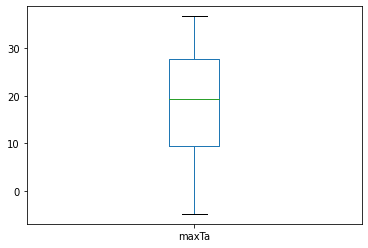

In [9]:
data.boxplot(column='maxTa', grid=False)
plt.show()

In [10]:
print(data.maxTa.max())
print(data.maxTa.min())
print(data.maxTa.median())
print(data.maxTa.mean())
print(data.maxTa.quantile(0.33))
print(data.maxTa.quantile(0.66))
data['Ta_gubun'] = pd.cut(data.maxTa, bins=[-5,13,26,37], labels=[0,1,2])

# data['Ta_gubun'] = pd.cut(data.maxTa, bins=[-5,13,26,37], labels=[0,1,2])

36.8
-4.9
19.35
18.597865853658536
12.8
26.082000000000004


In [11]:
data[data.Ta_gubun.isna()]

,YMD,CNT,maxTa,sumRn,Ta_gubun


- 본격적인 검정에 앞서 간단히 상관분석을 진행

In [12]:
data.corr()

,CNT,maxTa,sumRn
CNT,1.000000,-0.709555,-0.095322
maxTa,-0.709555,1.000000,0.119268
sumRn,-0.095322,0.119268,1.000000


- 세 그룹을 데이터를 나누어 준 뒤, 등분산 검정과 정규성 검정을 함께 수행

In [13]:
xs = [np.array(data[data.Ta_gubun == i]['CNT']) for i in range(3)]

[]

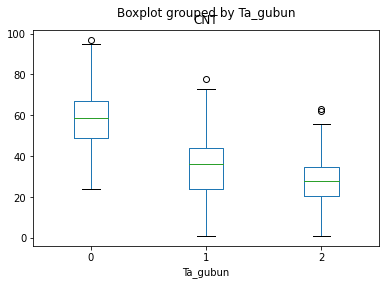

In [14]:
data.boxplot(column='CNT',by='Ta_gubun', grid=False)
plt.plot()

In [15]:
data.groupby('Ta_gubun').count()

,YMD,CNT,maxTa,sumRn
Ta_gubun,,,,
0,112,112,112,112
1,104,104,104,104
2,112,112,112,112


In [16]:
from scipy import stats
# 등분산 검정
print(stats.bartlett(xs[0],xs[1],xs[2]),stats.fligner(xs[0],xs[1],xs[2]), stats.levene(xs[0],xs[1],xs[2]), sep='\n')

BartlettResult(statistic=13.729198000455197, pvalue=0.0010441010529133724)
FlignerResult(statistic=12.015409721143207, pvalue=0.0024597271235625856)
LeveneResult(statistic=6.004297664820322, pvalue=0.0027503457908888405)


In [17]:
# 정규성 검정
print(stats.ks_2samp(xs[0],xs[1]), stats.ks_2samp(xs[1],xs[2]), stats.ks_2samp(xs[2],xs[1]), sep='\n')

KstestResult(statistic=0.6311813186813187, pvalue=1.1102230246251565e-16)
KstestResult(statistic=0.30494505494505497, pvalue=6.071012343955573e-05)
KstestResult(statistic=0.30494505494505497, pvalue=6.071012343955573e-05)


- 정규성 검정, 등분산 검정 둘다 만족하지 않음
## ANOVA 분석 진행
- 추후 정규성, 등분산성 조건 각각 충족하지 못하는 경우를 고려하여 추가분석도 진행

In [18]:
ssp = data.loc[:,['CNT','Ta_gubun']]
sp = np.array(ssp)

group1 = sp[sp[:,1]==0, 0]
group2 = sp[sp[:,1]==1, 0]
group3 = sp[sp[:,1]==2, 0]

#### scipy 패키지로 조회

In [19]:
F_statistic, pVal = stats.f_oneway(group1, group2, group3)
F_statistic, pVal

(155.19955180753786, 4.852594642037031e-48)

#### statsmodels 패키지로 조회

In [20]:
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

model = ols('CNT~C(Ta_gubun)', data).fit()
anova_lm(model)

,df,sum_sq,mean_sq,F,PR(>F)
C(Ta_gubun),2.0,57113.585935,28556.792968,155.199552,4.852595e-48
Residual,325.0,59800.157967,184.000486,NaN,NaN


- 유의수준(0.05) 이하이므로 귀무가설 기각

In [21]:
stats.kruskal(group1, group2, group3) # 정규성 가정x => Kruskal-Waliis test

KruskalResult(statistic=163.3689203627476, pvalue=3.348803662592121e-36)

- 정규성 가정이 충족하지 않을 때도 귀무가설 기각

In [22]:
# 등분산성 가정x => Welch's ANOVA

'''
conda install -c conda-forge pingouin
'''

from pingouin import welch_anova

aov = welch_anova(dv='CNT', between='Ta_gubun', data=data)
aov

,Source,ddof1,ddof2,F,p-unc,np2
0,Ta_gubun,2,208.781688,159.210562,1.011804e-42,0.48851


- 등분산성 가정을 만족하지 않았을 때도 귀무가설 기각
### 해석
- 날씨에 의해 매출건수의 차이가 유의미한 것으로 보여짐
- Boxplot을 살펴보니 날씨가 더울수록 주문량이 낮아지는것을 확인할 수 있음
- 더 자세히 살펴보기 위해 사후분석 진행

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj  lower    upper   reject
-----------------------------------------------------
     0      1  -23.171 0.001 -27.5204 -18.8216   True
     0      2 -30.6964 0.001 -34.9645 -26.4283   True
     1      2  -7.5254 0.001 -11.8748   -3.176   True
-----------------------------------------------------


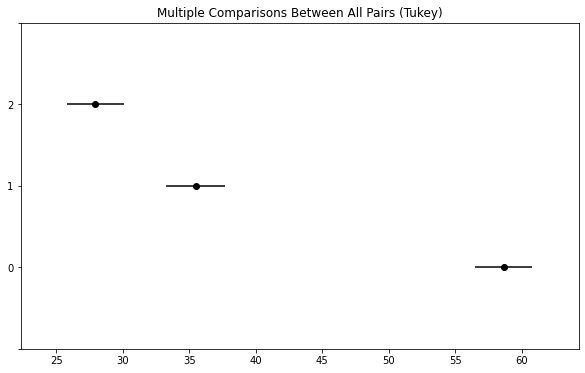

In [23]:
# 투키의 HSD

from statsmodels.stats.multicomp import pairwise_tukeyhsd
posthoc = pairwise_tukeyhsd(data['CNT'],data['Ta_gubun'], alpha=0.05)
print(posthoc)
fig = posthoc.plot_simultaneous()

- 유의 확률은 각각의 비교에서 모두 유의수준 이하 이므로 세 값의 평균은 모두 유의미한 차이를 가진다 판단할 수 있다
- 날씨 값의 범위가 모두 겹치지 않으므로 세 값은 모두 유의미한 차이를 가진다고 판단할 수 있다

In [24]:
# 본페로니 교정
    # Bonferroni correction
    # 모든 집단을 짝지어 t-test
    # 짝지어 비교를 3번 하면, p값을 3배
    # FWER이 중간 정도

# statsmodels 라이브러리 사용

from statsmodels.sandbox.stats.multicomp import MultiComparison

comp = MultiComparison(data.CNT, data.Ta_gubun)
result = comp.allpairtest(stats.ttest_ind, method='bonf')
print(result[0])

Test Multiple Comparison ttest_ind 
FWER=0.05 method=bonf
alphacSidak=0.02, alphacBonf=0.017
group1 group2   stat  pval pval_corr reject
-------------------------------------------
     0      1 11.4878  0.0       0.0   True
     0      2 17.7755  0.0       0.0   True
     1      2   4.286  0.0    0.0001   True
-------------------------------------------


In [25]:
# 본페로니 교정
# scikit-posthocs 라이브러리 사용
'''
conda install -c conda-forge scikit-posthocs

import scikit_posthocs as sp

sp.posthoc_conover(data,
                   val_col = '양적 자료',
                   group_col = '질적 자료',
                   p_adjust = 'holm')

# p_adjust : 다중비교(또는 사후분석)의 방법
# 'holm' : Bonferroni 방법
'''

import scikit_posthocs as sp
sp.posthoc_conover(data,
val_col='CNT',
group_col='Ta_gubun',
p_adjust = 'holm')

,0,1,2
0,1.000000e+00,2.557114e-28,2.257737e-48
1,2.557114e-28,1.000000e+00,1.238244e-06
2,2.257737e-48,1.238244e-06,1.000000e+00


In [26]:
# 셰페 방법
# 너무 민감하여 잘 사용하지 않음
sp.posthoc_scheffe(data, val_col='CNT', group_col='Ta_gubun')

,2,1,0
2,1.000000e+00,3.054481e-04,2.288899e-45
1,3.054481e-04,1.000000e+00,1.363219e-28
0,2.288899e-45,1.363219e-28,1.000000e+00


- 유의 확률은 각각의 비교에서 모두 유의수준 이하 이므로 세 값의 평균은 모두 유의미한 차이를 가진다 판단할 수 있다